In [69]:
from exceiver.models import Exceiver, ExceiverClassifier
from exceiver.datasets import ExceiverDataModule,ExceiverDataset
from scipy import sparse as sp
import scanpy as sc 
import pandas as pd
from tqdm import tqdm
from pathlib import  Path
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler
import torch
import joblib
import anndata as ad
import numpy as np

## Preprocessing

In [ ]:
adata = sc.read_csv("datasets/Guo/GSE99254.tsv",delimiter="\t")
if not sp.issparse(adata.X):
    adata.X  = sp.csr_matrix(adata.X)
adata.obs_names_make_unique()
adata.var_names_make_unique()
import pandas as pd
from sklearn.preprocessing import LabelEncoder
subtype = pd.read_csv("/scratch/saigum/exceiver/datasets/Guo/subtype.ann",delimiter="\t").set_index("UniqueCell_ID ")
subtype["cluster_no"] = LabelEncoder().fit_transform(subtype["sampleType"])
adata.obs["subtype"] = subtype.loc[adata.obs_names]["cluster_no"]
adata.write_h5ad(filename="datasets/Guo/GSE99254.h5ad")

## Collect Embeddings

In [71]:

batch_size=2
data_path = Path("/scratch/saigum/exceiver/processed/guo")
dm = ExceiverDataModule(data_path=data_path, classify="subtype", batch_size=64, num_workers=0)
dm.prepare_data()
dm.setup(stage='fit')
val_dataset = ExceiverDataset(dm.val_adata.X, classes=dm.val_classes, scaler=dm.val_scaler, n_mask=dm.n_mask, batch_size=batch_size, inference=True)
sampler = BatchSampler(SequentialSampler(val_dataset), batch_size=val_dataset.batch_size, drop_last=True)
dl = DataLoader(val_dataset, batch_size=None, batch_sampler=None, sampler=sampler, num_workers=0, pin_memory=True)
gpu = "cuda:1"
# Load model
model = Exceiver.load_from_checkpoint("pretrained_models/exceiver/pretrained_TS_exceiver.ckpt")
_ = model.eval()
_ = model.to(gpu)


emb = []
for batch in tqdm(dl):
    with torch.no_grad():
        batch = [i.to(gpu) if i is not None else i for i in batch]
        gene_ids, gene_vals, mask_ids, mask_vals, key_padding_mask, classify = batch
        input_query = model.query_emb.repeat(len(gene_ids), 1, 1)
        latent, encoder_weights = model.encoder_attn_step(gene_ids, gene_vals, input_query, key_padding_mask)
        latent = model.process_self_attn(latent)
        emb.append(latent.reshape(batch_size, -1).cpu())

# Concatenate and save to disk
emb = torch.cat(emb).numpy()
joblib.dump(emb, f"/scratch/saigum/exceiver/emb.joblib")

# Covnvert to AnnData object
emb_adata = ad.AnnData(X=emb.copy(), obs=dm.val_adata.obs[:len(emb)], var=pd.DataFrame({"emb_dim": np.arange(emb.shape[1])}))

# Compute UMAP
sc.pp.pca(emb_adata)
print("Computed PCA.")
sc.pp.neighbors(emb_adata, use_rep="X_pca")
print("Computed neighborhood graph.")
sc.tl.umap(emb_adata)
print("Computed UMAP.")

# Save to disk
emb_adata.write_h5ad(f"/scratch/saigum/exceiver/emb.h5ad")
print("Saved AnnData object to disk.")

n masked genes: 386


Lightning automatically upgraded your loaded checkpoint from v1.6.5 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint pretrained_models/exceiver/pretrained_TS_exceiver.ckpt`


train_adata shape: (8637, 18626)
val_adata shape: (3702, 18626)
preparing class labels for subtype


100%|██████████| 1851/1851 [00:12<00:00, 146.08it/s]
/scratch/saigum/test/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Computed PCA.


/scratch/saigum/test/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/saigum/test/lib/python3.13/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Computed neighborhood graph.
Computed UMAP.
Saved AnnData object to disk.


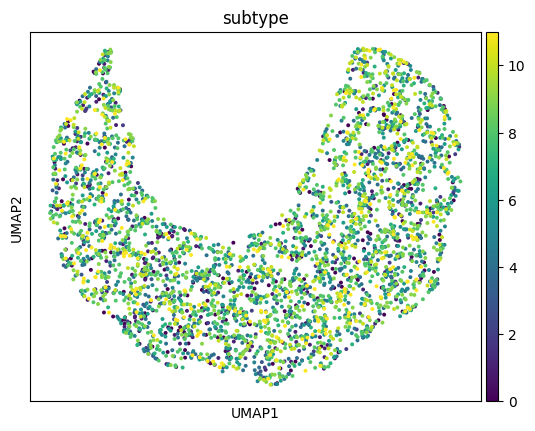

In [72]:
sc.pl.umap(emb_adata,color="subtype")

In [80]:
emb_adata.X

array([[ 1.3706132 , -0.19569024,  0.54568946, ..., -0.22663182,
         0.07791363, -1.2439821 ],
       [ 1.363689  , -0.19480519,  0.5511736 , ..., -0.22671516,
         0.08772886, -1.248459  ],
       [ 1.3332834 , -0.19193792,  0.5757178 , ..., -0.22797318,
         0.09915116, -1.2525592 ],
       ...,
       [ 1.3719891 , -0.20031571,  0.5482206 , ..., -0.23060808,
         0.10898118, -1.2546446 ],
       [ 1.3718599 , -0.19394991,  0.5431421 , ..., -0.2246931 ,
         0.06924635, -1.2416517 ],
       [ 1.3516709 , -0.19752596,  0.56407493, ..., -0.2308615 ,
         0.10630935, -1.2532182 ]], shape=(3702, 512), dtype=float32)

In [76]:
emb_adata.obs["subtype"]
# basic clustering check
sc.tl.leiden(adata=emb_adata,)

12

In [ ]:
fd = sc.read_h5ad("datasets/Guo/GSE99254.h5ad")
print(fd)
print(fd.X)